# Practical Session: Q-Learning

In this practical session, you will implement the famous [Q-Learning](https://link.springer.com/content/pdf/10.1007/BF00992698.pdf) algorithm and test it in various environments.

## Taxi V3

The taxi problem was first introduced in [Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition](https://arxiv.org/abs/cs/9905014).  
In this environment, the agent controls a taxi whose job is to pick up a passenger at one location and drop him off in his target location.  
Dropping of the passenger to its destination leads to a +20 reward.  
To encourage the agent to be as fast as possible, it receives a deceptive reward of -1 at each step.  
It will also receive a -10 penalty reward if it takes an illegal 'pick-up' or drop-off' action.  
Let's instantiate a Taxi-V3 environment:

In [1]:
import gym
env = gym.make("Taxi-v3")
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



The taxi is represented in <span style="color:yellow">yellow</span> when empty and in <span style="color:green">green</span> when full.  
The passenger is represented in <span style="color:blue">blue</span> and his destination in <span style="color:magenta">magenta</span>.

**Observations**: There are 500 discrete states since there are 25 taxi positions, five possible passenger locations (including the case when the passenger is in the taxi), and four destination locations.

In [2]:
print(f"State Space {env.observation_space}")

State Space Discrete(500)


The agent controling the *taxi* has six discrete and deterministic possibles actions:  
*  0: *move south*
*  1: *move north*
*  2: *move east*
*  3: *move west*
*  4: *pickup passenger*
*  5: *drop off passenger*  

In [3]:
print(f"Action Space {env.action_space}")

Action Space Discrete(6)


Here is a little method to vizualize our taxi's trajectory:

In [4]:
from IPython.display import clear_output
from time import sleep

def display_trajectory(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Reward: {frame['reward']}")
        sleep(.2)

# Random agent

The following code shows how to run an episode with an agent taking random actions.

In [5]:
frames = [] # for animation

env.reset()
while True:
    # draw a random action from the action space
    action = env.action_space.sample()
    # the step method takes an action as input and returns 4 variables described in the OpenAI section
    state, reward, done, info = env.step(action)
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'reward': reward
        })
    #if done is True then the episode is over
    if done == True:
        break
        
display_trajectory(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Timestep: 200
State: 341
Reward: -1


## Human policy 

In [6]:
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



We just saw a random policy. Let's now check on your policy.  
Using the possible actions, make a little script to take the client to his destination and visualize it with the `display_frames` method.

In [7]:
frames = [] 
actions = [3,3,0,3,3,1,1,4,0,0,2,2,2,0,0,5]
for a in actions:
    state, reward, _, _ = env.step(a)
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'reward': reward
        })

display_trajectory(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 16
State: 472
Reward: -10


# Q-learning
Let's now try to solve the TaxiV3 problem using the Q-learing algorithm.
![](images/q-learning.png)

Fill the `q_learning` method.

In [8]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns

def print_running_mean(training_rewards, i):
    clear_output(wait=True)
    plt.figure(figsize=(15,3))
    plt.plot(pd.Series(training_rewards[:i]).rolling(100).mean())
    plt.title("Rewards running mean on last 100 episodes")
    plt.show()

def q_learning(env, alpha, gamma, epsilon, nb_episodes):
    nb_states = env.observation_space.n
    nb_actions = env.action_space.n
    q_table = np.zeros([nb_states, nb_actions])
    training_rewards = np.zeros(nb_episodes)
    for i in range(nb_episodes):
        state = env.reset()
        while True:
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample() # Explore action space
            else:
                action = np.argmax(q_table[state]) # Exploit learned values

            next_state, reward, done, info = env.step(action) 

            old_value = q_table[state, action]
            next_max = np.max(q_table[next_state])

            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_value

            training_rewards[i] += reward
            state = next_state

            if done:
                break

        if i % 100 == 0:
            print_running_mean(training_rewards, i)

    return q_table

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-_ff_h2a2 because the default path (/home/david.bertoin/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Train your q-table.

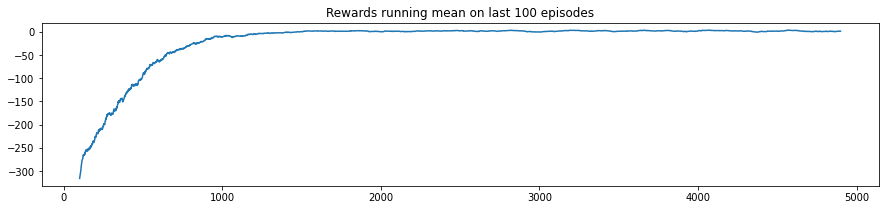

In [9]:
nb_episodes = 5000
alpha = 0.1
gamma = 0.99
epsilon = 0.1

q_table = q_learning(env, alpha, gamma, epsilon, nb_episodes)

Let us have a look at the learned policy.

In [10]:
env.reset()
frames = [] # for animation
timesteps = 0
while True:
    action = np.argmax(q_table[state])
    state, reward, done, info = env.step(action)
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'reward': reward
        }
    )

    timesteps += 1
    if done:
        break
        
display_trajectory(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 7
State: 475
Reward: 20


# Frozen lake
Now, try your algoithm on frozen lake.

In [11]:
import gym
env = gym.make("FrozenLake8x8-v0")
env.render()


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


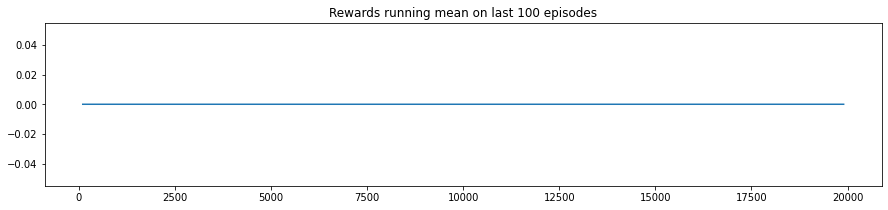

In [12]:
nb_episodes = 20000
alpha = 0.1
gamma = 0.99
epsilon = 0.1

q_table = q_learning(env, alpha, gamma, epsilon, nb_episodes)

Your agent has probably not reached a satisfying policy.  
This is due to the lack of exploration induced by the $\epsilon$-greedy policy.
Fixing $\epsilon$ to 0.1 is not sufficient in Frozen Lake. The agent does not explore enougth and thus never receives a positive feedback.  
A simple solution would be to use a decaying epsilon from 1 to 0.1.

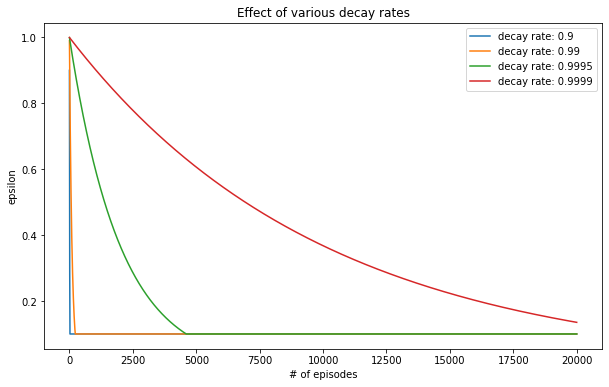

In [13]:
decay_rates = [0.9, 0.99, 0.9995, 0.9999]
eps_min = 0.1
plt.figure(figsize=(10,6))

for decay_rate in decay_rates:
    eps_list = []
    test_eps = 1
    for _ in range(nb_episodes):
        test_eps = max(test_eps * decay_rate, eps_min)
        eps_list.append(test_eps)          
    
    plt.plot(eps_list, label='decay rate: {}'.format(decay_rate))

plt.title('Effect of various decay rates')
plt.legend(loc='best')
plt.xlabel('# of episodes')
plt.ylabel('epsilon')
plt.show()

Modify your `q_learning` function to decay the learning rate after each episode (don't forget to clip so it does not go below 0.1).
Try your function with different values for `epsilon_decay`

In [14]:
def q_learning(env, alpha, gamma, epsilon_decay, nb_episodes):
    epsilon = 1
    min_epsilon = 0.1
    nb_states = env.observation_space.n
    nb_actions = env.action_space.n
    q_table = np.zeros([nb_states, nb_actions])
    training_rewards = np.zeros(nb_episodes)
    for i in range(nb_episodes):
        state = env.reset()
        while True:
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample() # Explore action space
            else:
                action = np.argmax(q_table[state]) # Exploit learned values

            next_state, reward, done, info = env.step(action) 

            old_value = q_table[state, action]
            next_max = np.max(q_table[next_state])

            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_value

            training_rewards[i] += reward
            state = next_state

            if done:
                epsilon *= epsilon_decay
                epsilon = max(epsilon, min_epsilon)
                break



        if i % 100 == 0:
            print_running_mean(training_rewards, i)
            
    return q_table

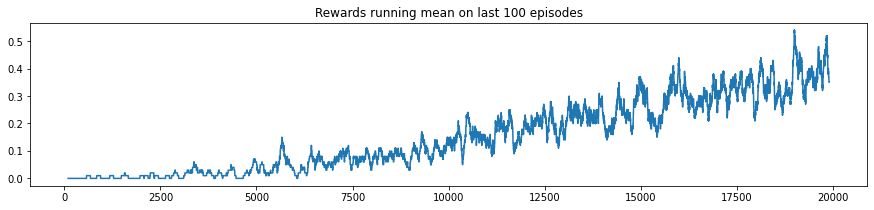

In [17]:
nb_episodes = 20000
alpha = 0.1
gamma = 0.99
epsilon_decay = 0.9999

q_table = q_learning(env, alpha, gamma, epsilon_decay, nb_episodes)

Let us have a look at the learned policy.

In [16]:
env.reset()
frames = [] # for animation
timesteps = 0
state = env.reset()
while True:
    action = np.argmax(q_table[state])
    state, reward, done, info = env.step(action)
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'reward': reward
        }
    )

    timesteps += 1
    if done:
        break
        
display_trajectory(frames)

  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

Timestep: 200
State: 24
Reward: 0.0


In these two environments, the State-space was discrete and small enough to learn the entire Q-table.
In most cases, this State space is way too large to learn the Q-values for each state.  
One solution is to learn an estimator of this Q-function.
In the following practical session, you will adapt the Q-learning algorithm to uses neural networks as function approximators.